In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

termcolor not installed, skipping dependency
No pygame installed, ignoring import
Loading environment lux_ai_s3 failed: No module named 'chex'


In [2]:
%%writefile rock_agent.py

#Example of the simple agent
#0 - rock
#1 - paper
#2 - scissors
def your_agent(observation, configuration):
    return 0

Writing rock_agent.py


In [3]:
%%writefile paper.py

#strategy with only papers
def paper(observation, configuration):
    return 1

Writing paper.py


In [4]:
%%writefile scissors.py

# strategy with only scissors
def scissors(observation, configuration):
    return 2

Writing scissors.py


In [5]:
%%writefile copy_opponent.py

import random  # Добавляем импорт random

def copy_opponent(observation, configuration):
    # Если у нас есть информация о последнем ходе противника
    if observation.step > 0:
        return observation.lastOpponentAction
    # Начальный шаг
    else:
        return random.randrange(0, configuration.signs)


Writing copy_opponent.py


In [6]:
%%writefile copy_opponent_shift.py

import random  # Добавляем импорт random

def copy_opponent(observation, configuration):
    # Если у нас есть информация о последнем ходе противника
    if observation.step > 0:
        return (observation.lastOpponentAction + 1)%3
    # Начальный шаг
    else:
        return random.randrange(0, configuration.signs)

Writing copy_opponent_shift.py


In [7]:
evaluate(
    "rps", #environment to use - no need to change
    ["rock_agent.py", "copy_opponent.py"], #agents to evaluate
    configuration={"episodeSteps": 100} #number of episodes
)

[[0, 0]]

In [8]:
evaluate(
    "rps", #environment to use - no need to change
    ["rock_agent.py", "scissors.py"], #agents to evaluate
    configuration={"episodeSteps": 100} #number of episodes
)

[[99.0, -99.0]]

In [9]:
%%writefile keep_strategy.py
import random
import math

my_action = []

def keep_strategy(observation, configuration):
    def get_score(left_move, right_move):
        # This method exists in this file so it can be consumed from rps.py and agents.py without a circular dependency
        delta = (
            right_move - left_move
            if (left_move + right_move) % 2 == 0
            else left_move - right_move
        )
        return 0 if delta == 0 else math.copysign(1, delta)
    global my_action
    if observation.step == 0:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    elif get_score(my_action[-1], observation.lastOpponentAction) == 1:
        answer = my_action[-1]
        my_action.append(answer)
    else:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    return answer

Writing keep_strategy.py


In [10]:
%%writefile throw_paper_if_win.py
import random
import math

my_action = []

def keep_strategy(observation, configuration):
    def get_score(left_move, right_move):
        # This method exists in this file so it can be consumed from rps.py and agents.py without a circular dependency
        delta = (
            right_move - left_move
            if (left_move + right_move) % 2 == 0
            else left_move - right_move
        )
        return 0 if delta == 0 else math.copysign(1, delta)
    global my_action
    if observation.step == 0:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    elif get_score(my_action[-1], observation.lastOpponentAction) == 1:
        answer = 1
        my_action.append(answer)
    else:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    return answer

Writing throw_paper_if_win.py


In [11]:
%%writefile random_goblin.py
import random


def random_goblin(observation, configuration):
    return random.randint(0, 2)

Writing random_goblin.py


In [12]:
%%writefile throw_scissors_if_lose.py
import random
import math

my_action = []

def keep_strategy(observation, configuration):
    """
    Keep stategy if win
    """
    def get_score(left_move, right_move):
        # This method exists in this file so it can be consumed from rps.py and agents.py without a circular dependency
        delta = (
            right_move - left_move
            if (left_move + right_move) % 2 == 0
            else left_move - right_move
        )
        return 0 if delta == 0 else math.copysign(1, delta)
    global my_action
    if observation.step == 0:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    elif get_score(my_action[-1], observation.lastOpponentAction) < 1:
        answer = 2
        my_action.append(answer)
    else:
        answer = random.randrange(0, configuration.signs)
        my_action.append(answer)
    return answer

Writing throw_scissors_if_lose.py


In [13]:
# Создаём среду для игры "Камень, ножницы, бумага"
env = make("rps",configuration={"episodeSteps": 1000}, debug=True)

# Запускаем игру с вашим агентом против самого себя
env.run(['random_goblin.py', 'paper'])

# Отображаем результаты игры
env.render(mode="ipython", width=500, height=400)
print(env)

In [14]:
%%writefile fixed_statistic.py
import random
import numpy

def fixed_statistic(observation, configuration):
    """
    Strategy based on https://avatars.dzeninfra.ru/get-zen_doc/3985649/pub_5faa46b389ace40d9a449e91_5faa816a9c3dc81f90d0e63e/scale_1200
    """
    all_results = [0]*int(configuration.episodeSteps*0.354)+[1]*int(configuration.episodeSteps*0.296) +\
     [2]*int(configuration.episodeSteps*0.35)
    return random.choice(all_results)

Writing fixed_statistic.py


In [15]:
%%writefile markov.py

import numpy as np
import collections

def markov_agent(observation, configuration):
    k = 2
    global table, action_seq
    if observation.step % 250 == 0: # refresh table every 250 steps
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])
        else:
            action_seq.append(action)
        return action
    # update table
    key = ''.join([str(a) for a in action_seq[:-1]])
    table[key][observation.lastOpponentAction] += 1
    # update action seq
    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    # predict opponent next move
    key = ''.join([str(a) for a in action_seq[:-1]])
    if observation.step < 500:
        next_opponent_action_pred = np.argmax(table[key])
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum()) # add stochasticity for second part of the game
    # make an action
    action = (next_opponent_action_pred + 1) % 3
    # if high probability to lose -> let's surprise our opponent with sudden change of our strategy
    if observation.step > 900:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Writing markov.py


In [16]:
%%writefile decision_tree.py

import numpy as np
import collections
from sklearn.tree import DecisionTreeClassifier

def construct_local_features(rollouts):
    step_mode_features = np.array([[step % k for step in rollouts['steps']] for k in (2, 3, 5)])
    step_div_features = np.array([[step // k for step in rollouts['steps']] for k in (100, 150, 250)])
    features = np.concatenate([step_mode_features, step_div_features])
    features = np.append(features, rollouts['actions'])
    features = np.append(features, rollouts['opp-actions'])
    return features

def construct_global_features(rollouts):
    features = []
    for key in ['actions', 'opp-actions']:
        for i in range(3):
            actions_count = np.mean([r == i for r in rollouts[key]])
            features.append(actions_count)
    return np.array(features)

def construct_features(short_stat_rollouts, long_stat_rollouts):
    lf = construct_local_features(short_stat_rollouts)
    gf = construct_global_features(long_stat_rollouts)
    features = np.concatenate([lf, gf])
    return features

def predict_opponent_move(train_data, test_sample):
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(train_data['x'], train_data['y'])
    return classifier.predict(test_sample)

def update_rollouts_hist(rollouts_hist, last_move, opp_last_action):
    rollouts_hist['steps'].append(last_move['step'])
    rollouts_hist['actions'].append(last_move['action'])
    rollouts_hist['opp-actions'].append(opp_last_action)
    return rollouts_hist

def warmup_strategy(observation, configuration):
    global rollouts_hist, last_move
    action = int(np.random.randint(3))
    if observation.step == 0:
        last_move = {'step': 0, 'action': action}
        rollouts_hist = {'steps': [], 'actions': [], 'opp-actions': []}
    else:
        rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
        last_move = {'step': observation.step, 'action': action}
    return int(action)

def init_training_data(rollouts_hist, k):
    for i in range(len(rollouts_hist['steps']) - k + 1):
        short_stat_rollouts = {key: rollouts_hist[key][i:i+k] for key in rollouts_hist}
        long_stat_rollouts = {key: rollouts_hist[key][:i+k] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, long_stat_rollouts)
        data['x'].append(features)
    test_sample = data['x'][-1].reshape(1, -1)
    data['x'] = data['x'][:-1]
    data['y'] = rollouts_hist['opp-actions'][k:]
    return data, test_sample

def agent(observation, configuration):
    # hyperparameters
    k = 5
    min_samples = 25
    global rollouts_hist, last_move, data, test_sample
    if observation.step == 0:
        data = {'x': [], 'y': []}
    # if not enough data -> randomize
    if observation.step <= min_samples + k:
        return warmup_strategy(observation, configuration)
    # update statistics
    rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
    # update training data
    if len(data['x']) == 0:
        data, test_sample = init_training_data(rollouts_hist, k)
    else:
        short_stat_rollouts = {key: rollouts_hist[key][-k:] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, rollouts_hist)
        data['x'].append(test_sample[0])
        data['y'] = rollouts_hist['opp-actions'][k:]
        test_sample = features.reshape(1, -1)

    # predict opponents move and choose an action
    next_opp_action_pred = predict_opponent_move(data, test_sample)
    action = int((next_opp_action_pred + 1) % 3)
    last_move = {'step': observation.step, 'action': action}
    return action

Writing decision_tree.py


In [17]:
import os

agents = [file for file in os.listdir() if file.endswith('.py')]
agents
dict_win = {agent: [0, 0, 0] for agent in agents}

In [18]:
np.rps = []
for i in range(len(agents)):
  np.rps_row = []
  a = 0
  for j in range(len(agents)):
    one_set = []
    one_set = evaluate(
                        "rps", #environment to use - no need to change
                        [agents[i], agents[j]], #agents to evaluate
                        configuration={"episodeSteps": 70, 'tieRewardThreshold': 1} #number of episodes
                      )
    print(agents[i], agents[j])
    np.rps_row += one_set
    print(one_set)
    if one_set[0][0] > one_set[0][1]:
      dict_win[agents[i]][0] += 1
    elif one_set[0][0] < one_set[0][1]:
      dict_win[agents[i]][1] += 1
    else:
      dict_win[agents[i]][2] += 1

  np.rps.append(np.rps_row)

copy_opponent.py copy_opponent.py
[[0, 0]]
copy_opponent.py copy_opponent_shift.py
[[-34.0, 34.0]]
copy_opponent.py decision_tree.py
[[-40.0, 40.0]]
copy_opponent.py fixed_statistic.py
[[2.0, -2.0]]
copy_opponent.py keep_strategy.py
[[4.0, -4.0]]
copy_opponent.py markov.py
[[-46.0, 46.0]]
copy_opponent.py paper.py
[[1.0, -1.0]]
copy_opponent.py random_goblin.py
[[-7.0, 7.0]]
copy_opponent.py rock_agent.py
[[1.0, -1.0]]
copy_opponent.py scissors.py
[[0, 0]]
copy_opponent.py throw_paper_if_win.py
[[1.0, -1.0]]
copy_opponent.py throw_scissors_if_lose.py
[[1.0, -1.0]]
copy_opponent_shift.py copy_opponent.py
[[34.0, -34.0]]
copy_opponent_shift.py copy_opponent_shift.py
[[0, 0]]
copy_opponent_shift.py decision_tree.py
[[-45.0, 45.0]]
copy_opponent_shift.py fixed_statistic.py
[[6.0, -6.0]]
copy_opponent_shift.py keep_strategy.py
[[17.0, -17.0]]
copy_opponent_shift.py markov.py
[[-44.0, 44.0]]
copy_opponent_shift.py paper.py
[[69.0, -69.0]]
copy_opponent_shift.py random_goblin.py
[[-7.0, 7.0]]

In [19]:
colName = ["Побед", "Поражний", "Ничьих"]
df = pd.DataFrame.from_dict(dict_win, orient='index', columns=colName)
df = df.sort_values("Побед",ascending = False)
df

,Побед,Поражний,Ничьих
decision_tree.py,11,1,0
copy_opponent_shift.py,8,3,1
keep_strategy.py,7,5,0
markov.py,7,3,2
copy_opponent.py,6,4,2
rock_agent.py,5,6,1
throw_scissors_if_lose.py,5,6,1
fixed_statistic.py,4,7,1
throw_paper_if_win.py,4,8,0
paper.py,3,8,1


<Axes: >

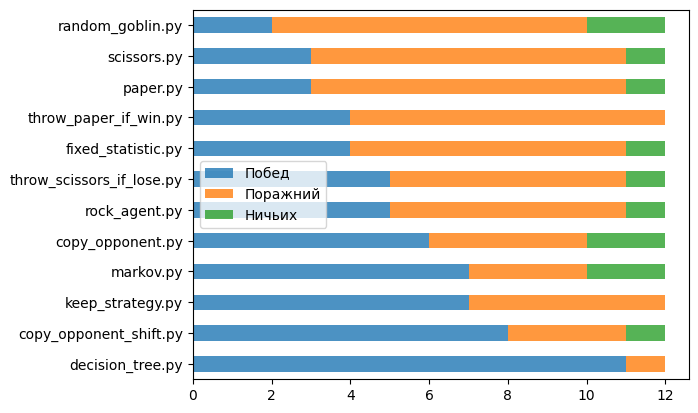

In [20]:
df.plot.barh(stacked=True, alpha=0.8)